# New York City AirBnB Data Modeling and Analysis

Made for the University of San Diego
Course: AAI-510 (Machine learning: Fundamentals and Applications)
Professor: Wesley Pasfield, MS

By - Doug Code (dcode15), Subhabrata Ganguli (suvoganguli), Jeffrey Lehrer (J-Lehrer)

# Problem statement and justification for the proposed approach.


Business understanding - What does the business need?




## [Modify as necessary]

## Introduction

Airbnb, an online marketplace for lodging, has transformed the way people travel and find accommodations. In major cities like New York City, Airbnb listings provide a wide variety of options for travelers, ranging from entire apartments and homes to private rooms in shared apartments. This flexibility has made Airbnb a popular choice among both tourists and business travelers.

In this notebook, we will explore the Airbnb dataset for New York City. This dataset provides detailed information on listings available on Airbnb, including prices, locations, types of properties, and reviews. By analyzing this data, we can gain insights into the rental market in New York City, understand pricing strategies, identify popular neighborhoods, and much more.

## Dataset Description

The dataset used in this analysis is obtained from [Inside Airbnb](http://insideairbnb.com/get-the-data.html), a website that provides publicly available data on Airbnb listings. 

## Objectives

In this analysis, the business needs are to achieve the following objectives:

1. **Data Exploration**: Understand the structure and contents of the dataset through summary statistics and visualizations.
2. **Price Analysis**: Analyze the pricing strategies of different types of listings and identify factors influencing prices.
3. **Geographical Analysis**: Examine the geographical distribution of listings and identify popular neighborhoods.
4. **Regression Analysis**: Predict the price of listing based on the test data


In [27]:
import optuna
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

from evaluation.ModelEvaluator import ModelEvaluator
from preprocessing.ColumnEncoder import ColumnEncoder
from preprocessing.ColumnSelector import ColumnSelector
from preprocessing.DataCleaner import DataCleaner
from preprocessing.DataImputer import DataImputer
from tuners.GradientBoostingRegressorTuner import GradientBoostingRegressorTuner
from tuners.HistGradientBoostingRegressorTuner import HistGradientBoostingRegressorTuner
from tuners.RandomForestRegressorTuner import RandomForestRegressorTuner
from tuners.XGBRegressorTuner import XGBRegressorTuner

# Data understanding (EDA) – a graphical and non-graphical representation of relationships between the response variable and predictor variables.


Data understanding - What data do we have/need? Is it clean?


In [3]:
# Read data

df = pd.read_csv("../data/listings-full.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,30314819,https://www.airbnb.com/rooms/30314819,20240406173624,2024-04-07,previous scrape,Brooklyn Finest Air Bnb,THE GUEST'S WILL HAVE ACCESS TO LOTS OF RESTAU...,NaN,https://a0.muscache.com/pictures/1ababa1b-a7d1...,224699779,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,30391955,https://www.airbnb.com/rooms/30391955,20240406173624,2024-04-07,previous scrape,Queens Comfort,Quiet neighborhood with plenty of on street pa...,10 min walk to Sutphin Av Archer Av Station wh...,https://a0.muscache.com/pictures/8d63479f-f4b6...,228213504,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
2,30378211,https://www.airbnb.com/rooms/30378211,20240406173624,2024-04-07,previous scrape,Shared Studio (females only),Bunk bed is shared with 1 other roommate (fema...,NaN,https://a0.muscache.com/pictures/500a4692-45da...,200401254,...,NaN,NaN,NaN,NaN,f,1,0,0,1,NaN
3,30459160,https://www.airbnb.com/rooms/30459160,20240406173624,2024-04-07,previous scrape,Large 2 Bedroom Apt - Close to everything!,Welcome to my massive two bedroom apt in eleva...,NaN,https://a0.muscache.com/pictures/a28e27f9-2360...,84147508,...,5.0,5.0,5.0,NaN,f,1,1,0,0,0.02
4,30746536,https://www.airbnb.com/rooms/30746536,20240406173624,2024-04-07,previous scrape,Stylish Single Room in Hell’s Kitchen,NaN,NaN,https://a0.muscache.com/pictures/6879386e-5133...,20416352,...,5.0,5.0,3.0,NaN,f,1,0,1,0,0.02


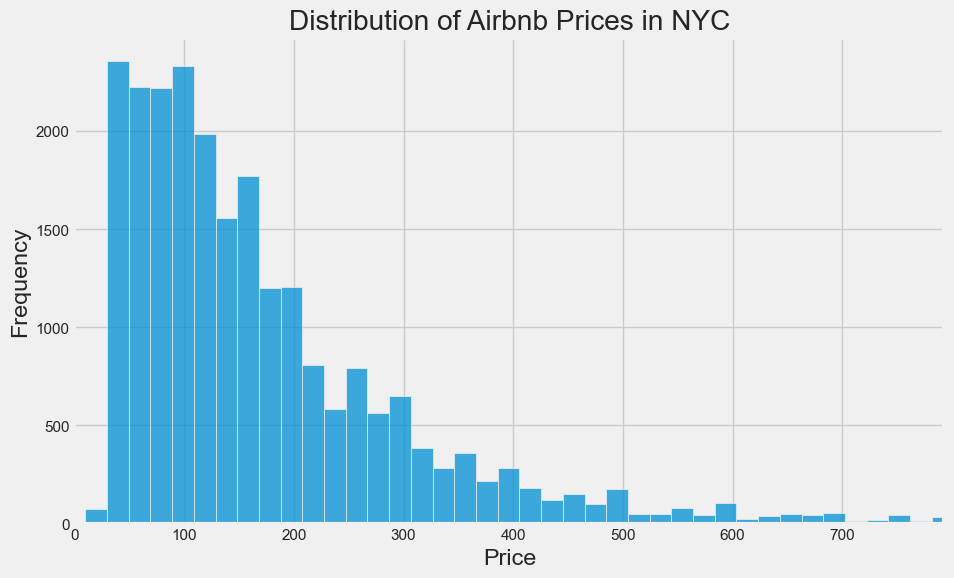

In [4]:
df['price'] = df['price'].str.replace('$', '', regex=False).replace('None', None).replace('', None)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Set styles for the plots
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")

# Histogram for price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=False)
plt.title('Distribution of Airbnb Prices in NYC')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, df['price'].quantile(0.99))  # To limit the x-axis to the 99th percentile to avoid extreme outliers
plt.show()

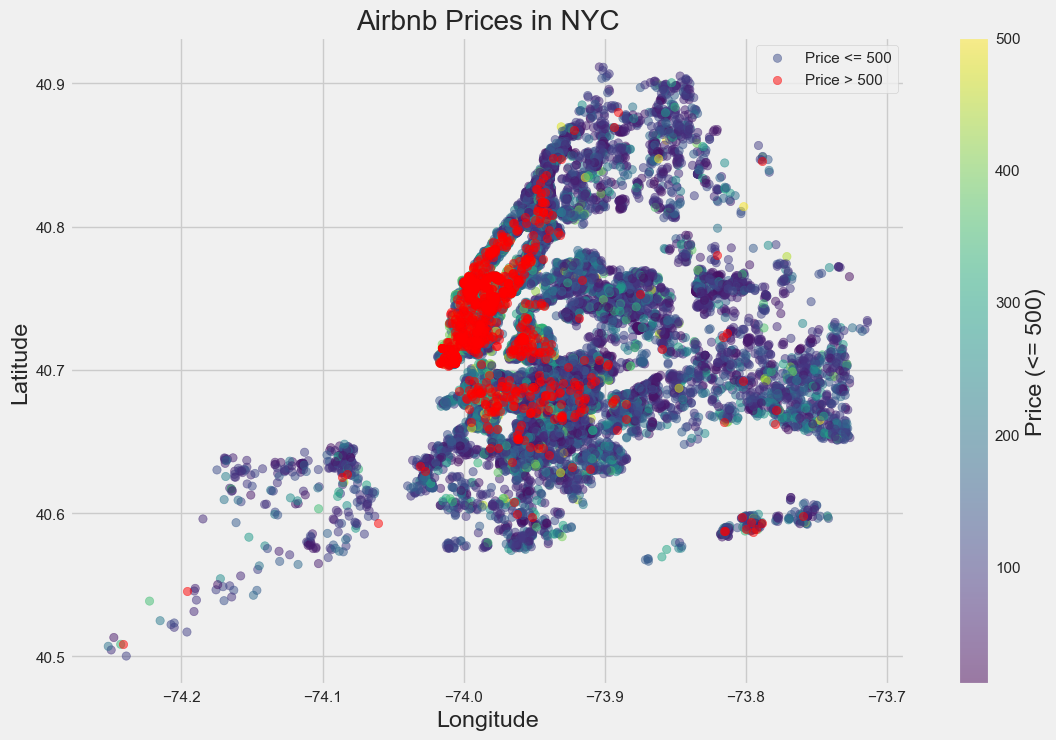

In [5]:
# Split the data into two groups
df_below_500 = df[df['price'] <= 500]
df_above_500 = df[df['price'] > 500]

# Plot the data
plt.figure(figsize=(12, 8))

# Scatter plot for prices <= 500
sc = plt.scatter(df_below_500['longitude'], df_below_500['latitude'], c=df_below_500['price'], cmap='viridis', alpha=0.5, label='Price <= 500')

# Scatter plot for prices > 1000
plt.scatter(df_above_500['longitude'], df_above_500['latitude'], color='red', alpha=0.5, label='Price > 500')

# Add color bar for the price <= 1000 points
cbar = plt.colorbar(sc, label='Price (<= 500)')

# Add titles and labels
plt.title('Airbnb Prices in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/var/folders/d7/3y4pn1x55_583bts49jyqlxh0000gn/T/ipykernel_66552/755991337.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


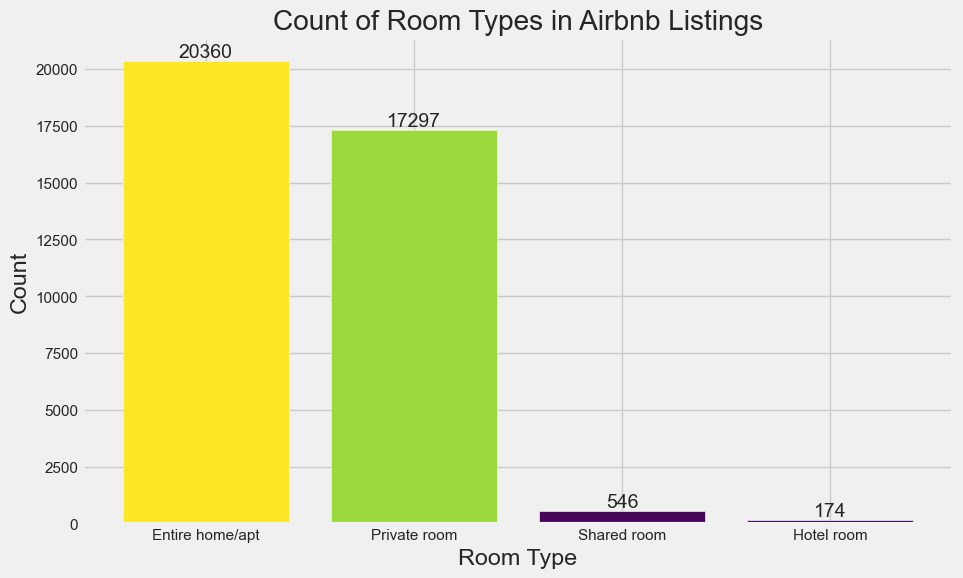

In [6]:
# Count the occurrences of each room type
room_type_counts = df['room_type'].value_counts()

# Get the viridis colormap
cmap = cm.get_cmap('viridis')

# Normalize the color range
norm = plt.Normalize(room_type_counts.min(), room_type_counts.max())
colors = cmap(norm(room_type_counts.values))

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(room_type_counts.index, room_type_counts.values, color=colors)

# Add titles and labels
plt.title('Count of Room Types in Airbnb Listings')
plt.xlabel('Room Type')
plt.ylabel('Count')

# Add value labels on the bars
for index, value in enumerate(room_type_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

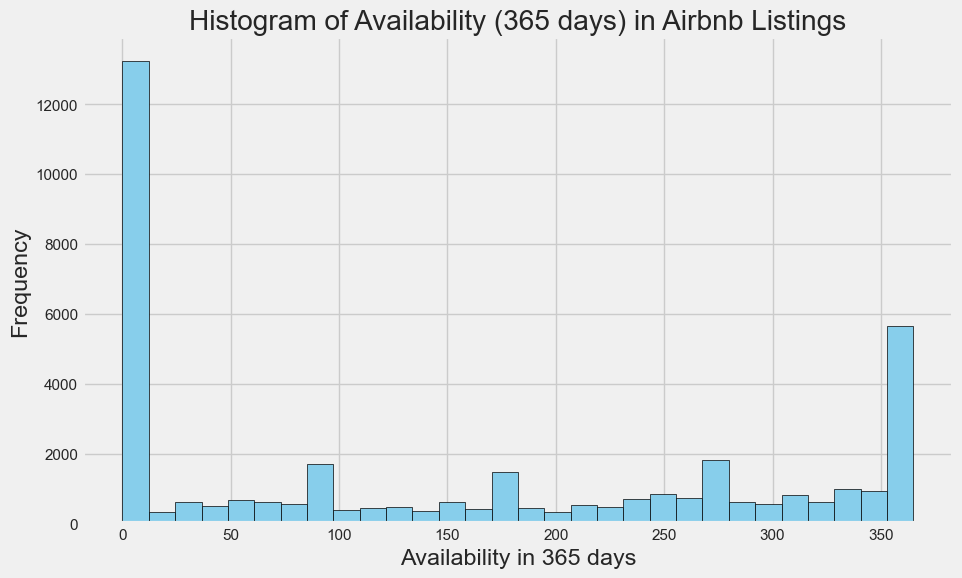

In [7]:
# Plot the histogram for availability_365
plt.figure(figsize=(10, 6))
plt.hist(df['availability_365'], bins=30, edgecolor='black', color='skyblue')

# Add titles and labels
plt.title('Histogram of Availability (365 days) in Airbnb Listings')
plt.xlabel('Availability in 365 days')
plt.ylabel('Frequency')

plt.show()

## Boxplots for categorical features

The following plots show that there are several outliers corresponding to high price values. This can mean that we will not get a high R^2 score for regression since the variance of the price data is high.

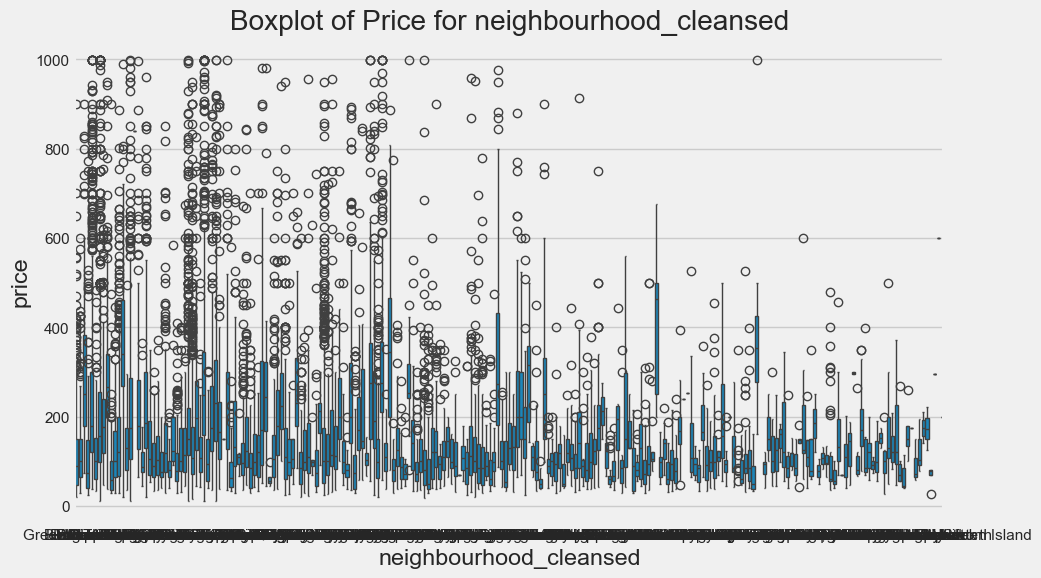

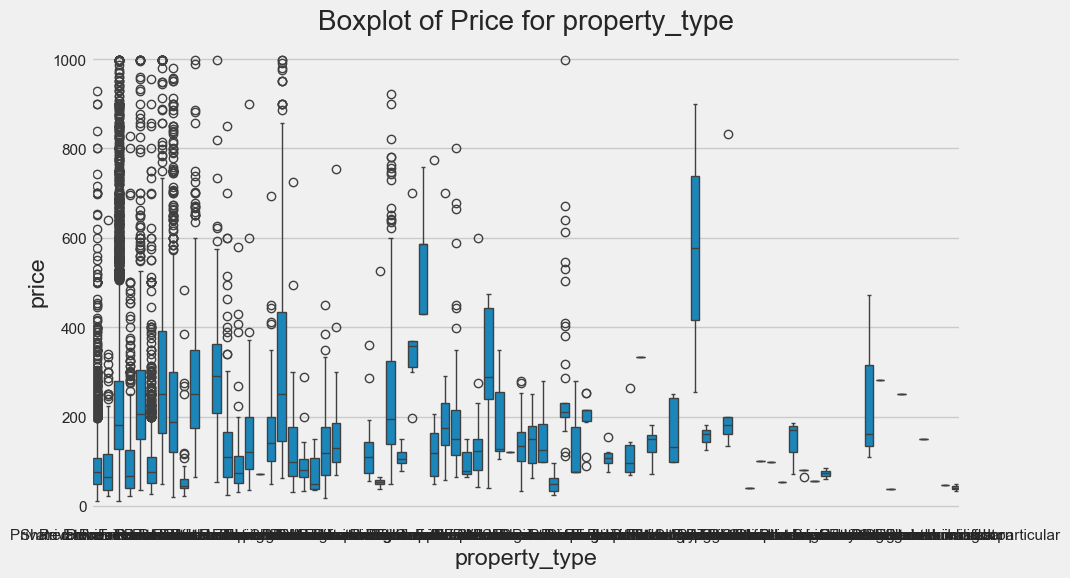

In [45]:
# Select the columns for train and test datasets
xy_train = df.copy()
xy_test = df.copy()

# Remove % sign and convert to numeric
xy_train['host_response_rate'] = xy_train['host_response_rate'].str.rstrip('%').astype('float') / 100
xy_train['host_acceptance_rate'] = xy_train['host_acceptance_rate'].str.rstrip('%').astype('float') / 100
xy_test['host_response_rate'] = xy_test['host_response_rate'].str.rstrip('%').astype('float') / 100
xy_test['host_acceptance_rate'] = xy_test['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

# Identifying categorical features
categorical_features = xy_train.select_dtypes(include=['object']).columns

# Plotting boxplots for each categorical feature against price
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='price', data=xy_train)
    plt.title(f'Boxplot of Price for {feature}')
    plt.show()

# Data Preparation

To prepare the data for feature engineering, the following tasks were carried out:
* Non-training features like image urls were removed from the data
* Features that had formatting which prevented them from being properly typed by pands, like features with "$" or "%" signs in them were converted to the appropriate data type.
* A set of additional location-based features were created. These features are prefixed with "dist_", and measure the AirBnBs geographic distance from a number of key attractions around New York City. This allows the model to adjust prices for rentals near major tourist centers.
* All amenities listed on all listings were aggregated and counted. To prevent a very large number of additional features from more obscure amenities, the top 50 most common amenities were added as boolean features with prefix "amenity_".

In [2]:
# Perform initial data cleaning
data_path: str = "../data/listings-full.csv"
data: pd.DataFrame = pd.read_csv(data_path)
data = DataCleaner.perform_base_cleaning(data)
data = DataImputer.remove_outliers_iqr(data, ["price"])

# Feature Engineering

A mixture of median, on-hot, label and frequency encoding were used based on a mixture of analyzing each categorical feature and model-based experimentation. For example, the `host_response_time` feature has inherent cardinality so label encoding was used.

In [3]:
# Encode categorical columns
median_encode_columns = ['neighbourhood_cleansed']
one_hot_columns = ['neighbourhood_group_cleansed', 'property_type']
label_encode_columns = ['host_response_time']
frequency_encode_columns = ['room_type']

data = ColumnEncoder.one_hot_encode_columns(data, one_hot_columns)
data = ColumnEncoder.label_encode_columns(data, label_encode_columns)

train_data, val_data, test_data = DataCleaner.split_train_val_test(data)

train_data = ColumnEncoder.median_encode_columns(train_data, median_encode_columns, "price")
val_data = ColumnEncoder.median_encode_columns(val_data, median_encode_columns, "price")
test_data = ColumnEncoder.median_encode_columns(test_data, median_encode_columns, "price")

train_data = ColumnEncoder.frequency_encode_columns(train_data, frequency_encode_columns)
val_data = ColumnEncoder.frequency_encode_columns(val_data, frequency_encode_columns)
test_data = ColumnEncoder.frequency_encode_columns(test_data, frequency_encode_columns)

Mean, median, most frequent, and constant imputation were used for missing values. Columns were again assigned to each technique based on a mixture of analysis and model-based experimentation. Due to the relatively large number of columns that needed to be imputed, this process relied more on automated experimentation than the encoding process. In the automated experimentation, models were generated using different imputation methods for each column and results were compared to find the most effective method.

In [4]:
# Impute missing values
mean_impute_columns = ['host_listings_count', 'room_type', 'accommodates', 'minimum_nights', 'maximum_minimum_nights',
                       'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm',
                       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'calculated_host_listings_count',
                       'dist_empire_state_building', 'dist_laguardia']
most_frequent_impute_columns = ['host_response_time', 'host_is_superhost', 'minimum_nights_avg_ntm', 'availability_60',
                                'availability_365', 'calculated_host_listings_count_shared_rooms', 'dist_high_line',
                                'dist_st_georges_theatre']
constant_impute_columns = ['neighbourhood_cleansed', 'maximum_nights', 'minimum_minimum_nights', 'availability_90',
                           'number_of_reviews', 'dist_central_park', 'dist_brooklyn_bridge']

train_data = DataImputer.impute_missing_values(train_data, mean_impute_columns, SimpleImputer(strategy="mean"))
val_data = DataImputer.impute_missing_values(val_data, mean_impute_columns, SimpleImputer(strategy="mean"))
test_data = DataImputer.impute_missing_values(test_data, mean_impute_columns, SimpleImputer(strategy="mean"))

train_data = DataImputer.impute_missing_values(train_data, most_frequent_impute_columns,
                                               SimpleImputer(strategy="most_frequent"))
val_data = DataImputer.impute_missing_values(val_data, most_frequent_impute_columns,
                                             SimpleImputer(strategy="most_frequent"))
test_data = DataImputer.impute_missing_values(test_data, most_frequent_impute_columns,
                                              SimpleImputer(strategy="most_frequent"))

train_data = DataImputer.impute_missing_values(train_data, constant_impute_columns,
                                               SimpleImputer(strategy="constant", fill_value=-9999))
val_data = DataImputer.impute_missing_values(val_data, constant_impute_columns,
                                             SimpleImputer(strategy="constant", fill_value=-9999))
test_data = DataImputer.impute_missing_values(test_data, constant_impute_columns,
                                              SimpleImputer(strategy="constant", fill_value=-9999))

train_data = DataImputer.impute_missing_values(train_data, data.columns, SimpleImputer(strategy="median"))
val_data = DataImputer.impute_missing_values(val_data, data.columns, SimpleImputer(strategy="median"))
test_data = DataImputer.impute_missing_values(test_data, data.columns, SimpleImputer(strategy="median"))

x_train, y_train, x_val, y_val, x_test, y_test = DataCleaner.perform_x_y_split(train_data, val_data, test_data)

To decided on an ideal number of features, models were trained with different numbers of features ranging from 5 to 170. In each run, features were removed using recursive feature elimination until the desired feature count was achieved. Due to the amount of computation time required for this, the process was run once outside the Jupyter Notebook to collect the data shown here.

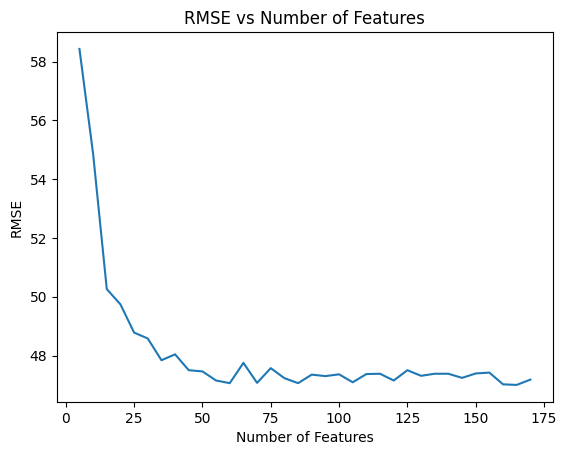

In [29]:
# Plot number of features in model vs RMSE
n_features_rmse = {5: 58.43, 10: 54.86, 15: 50.26, 20: 49.74, 25: 48.78, 30: 48.58, 35: 47.84, 40: 48.04, 45: 47.50, 50: 47.46, 55: 47.15, 60: 47.06, 65: 47.75, 70: 47.07, 75: 47.57, 80: 47.23, 85: 47.06, 90: 47.35, 95: 47.30, 100: 47.36, 105: 47.09, 110: 47.37, 115: 47.38, 120: 47.15, 125: 47.50, 130: 47.31, 135: 47.38, 140: 47.38, 145: 47.24, 150: 47.39, 155: 47.42, 160: 47.02, 165: 47.00, 170: 47.18}

features = list(n_features_rmse.keys())
rmses = list(n_features_rmse.values())

plt.plot(features, rmses)
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.show()

Based on the results shown above, the performance of the model increased consistently until 60 features, then leveled off with further feature additions. Based on this, 60 was chosen as the optimal number of features to include to minimize dimensionality while maximizing performance.

Using recursive feature elimination, the number of features in the dataset was decreased from 174 to 60. Examining the chosen features shows a wide range of feature types contributing to the model, including host information, rental size, rental availability, reviews, and room type. A number of the engineered amenity and location-distance features were also included.

In [5]:
# Use recursive feature elimination for feature selection
n_features = 60
top_columns = ColumnSelector.recursive_feature_elimination(x_train, y_train, n_features)
print(f"Top columns: {top_columns}")
x_train = x_train[top_columns]
x_val = x_val[top_columns]
x_test = x_test[top_columns]

Top columns: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'longitude', 'dist_times_square', 'dist_central_park', 'dist_empire_state_building', 'dist_statue_of_liberty', 'dist_brooklyn_bridge', 'dist_high_line', 'dist_gantry_plaza', 'amenity_ha

# Modeling

## Histogram Gradient Boosting Algorithm

In [6]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
# Tune histogram gradient boosting regressor hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(HistGradientBoostingRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'learning_rate': 0.10843781383787221, 'max_iter': 324, 'max_depth': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.44070390480011, 'max_leaf_nodes': 172, 'max_bins': 254, 'early_stopping': True, 'validation_fraction': 0.1594203268181018, 'tol': 0.0007295260718517506}


In [13]:
# Train histogram gradient boosting regressor model
model = HistGradientBoostingRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2451.6324127017765, 'rmse': 49.513961795656954, 'mae': 33.514247154517186}


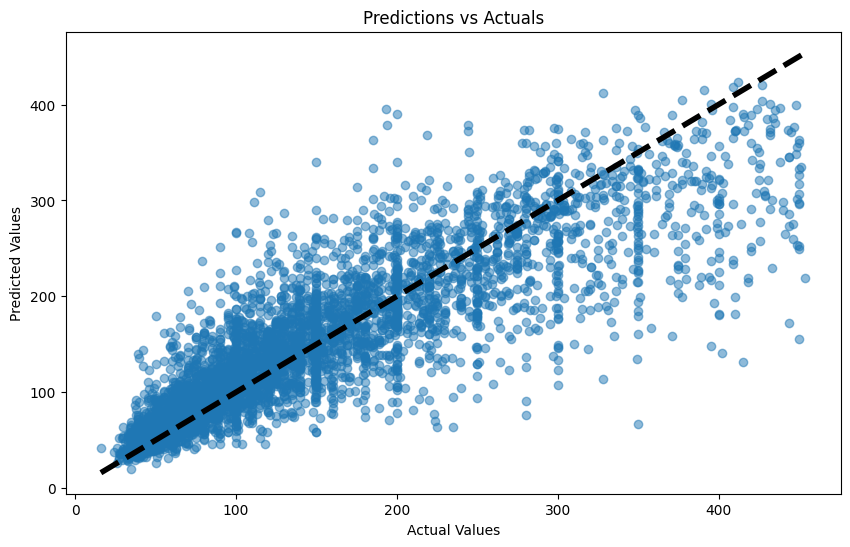

In [15]:
# Evaluate histogram gradient boosting regressor model
preds = model.predict(x_test)
print(ModelEvaluator.get_key_metrics(y_test, preds))
ModelEvaluator.plot_predictions_vs_actuals(y_test, preds)

## Random Forest Regressor

In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(RandomForestRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 177, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [17]:
model = RandomForestRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2491.796654390119, 'rmse': 49.91789913838641, 'mae': 33.867149085426256}


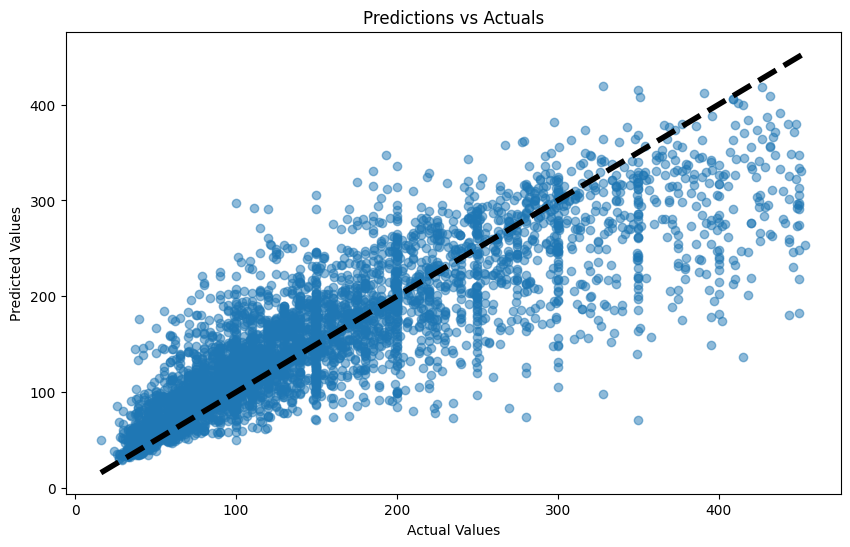

In [18]:
preds = model.predict(x_test)
print(ModelEvaluator.get_key_metrics(y_test, preds))
ModelEvaluator.plot_predictions_vs_actuals(y_test, preds)

## Gradient Boosting Regressor Algorithm

In [19]:
study = optuna.create_study(direction='minimize')
study.optimize(GradientBoostingRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 276, 'learning_rate': 0.037797462675686185, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9380943696443256, 'max_features': 'log2'}


In [20]:
model = GradientBoostingRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2300.891032437831, 'rmse': 47.96760398891976, 'mae': 32.334842620057984}


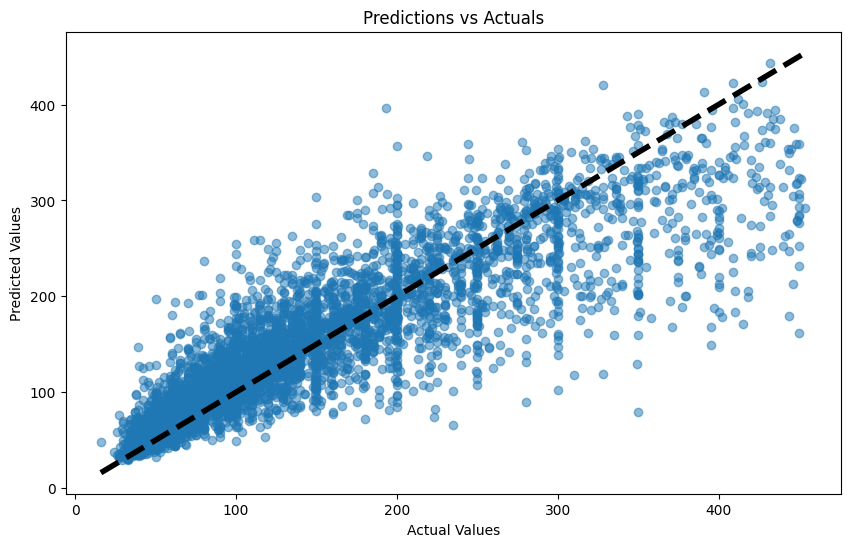

In [21]:
preds = model.predict(x_test)
print(ModelEvaluator.get_key_metrics(y_test, preds))
ModelEvaluator.plot_predictions_vs_actuals(y_test, preds)

## Extreme Gradient Boosting Regressor Algorithm

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(XGBRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 280, 'learning_rate': 0.0893511928305622, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.12817825328271884, 'subsample': 0.5007138526715688, 'colsample_bytree': 0.5210242609214725, 'reg_alpha': 0.8902186308454083, 'reg_lambda': 0.4807324151988472}


In [23]:
model = XGBRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2586.4096681578867, 'rmse': 50.85675636685736, 'mae': 34.077868399743146}


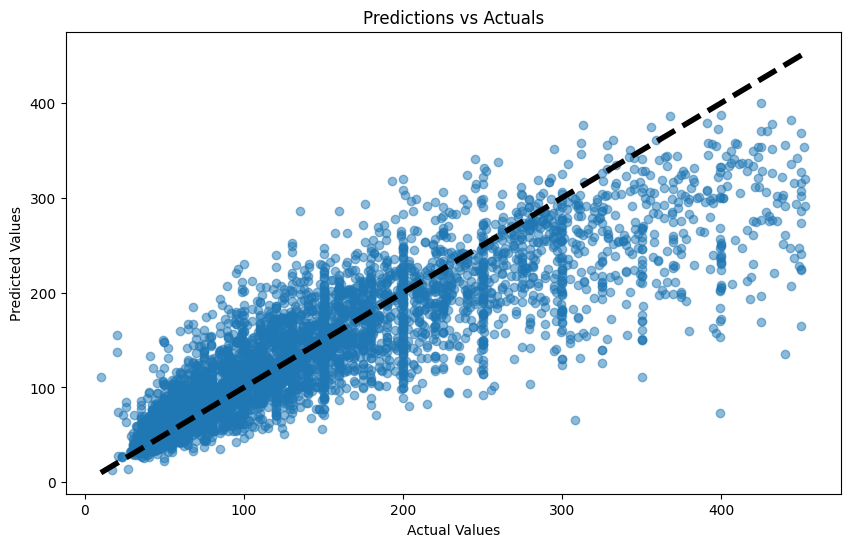

In [24]:
val_preds = model.predict(x_val)
print(ModelEvaluator.get_key_metrics(y_val, val_preds))
ModelEvaluator.plot_predictions_vs_actuals(y_val, val_preds)

# Evaluation – performance measures, results, and conclusions.


Evaluation - Which model best meets the business objectives?

The R^2 scores for the algorithms used are as follows:
1. **Histogram Gradient Boosting Algorithm**: 0.738
2. **Random Forest Regressor**: 0.709
4. **Gradient Boosting Regressor Algorithm**: 0.738
5. **Extreme Gradient Boosting Regressor Algorithm**: 0.734

Based on the above both Histogram Gradient Boosting Algorithm or Gradient Boosting Regressor Algorithm are giving highest score of 0.738. Hence, either of them can be used.

# Discussion and conclusions – address the problem statement and recommendation.

Deployment - How to get the model in production and ensure it works?

# References and Sources

GitHub link: https://github.com/suvoganguli/AAI510_FinalProject

